In [11]:
from IPython.display import Image

In [40]:
%%file bouncing_vehicle.py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import pyNN.hardware.spikey as pynn

print pynn.IF_facets_hardware1.default_parameters

pynn.setup(mappingOffset=0, calibSynDrivers=False, calibNeuronMems=False)

bounce_exc = [100.0, 700.0]
bounce_inh = [500.0, 800.0]

spike_train_exc = np.array(bounce_exc)
spike_train_inh = np.array(bounce_inh)
spike_train_bias = np.arange(0, 1000.0, 1.0)

stim_exc = pynn.Population( 10, pynn.SpikeSourceArray, {'spike_times': spike_train_exc})
stim_inh = pynn.Population(10, pynn.SpikeSourceArray, {'spike_times': spike_train_inh})
stim_bias = pynn.Population(3, pynn.SpikeSourceArray, {'spike_times': spike_train_bias})


brain = pynn.Population(5, pynn.IF_facets_hardware1)
inv_dummy = pynn.Population(5, pynn.IF_facets_hardware1)
inv = pynn.Population(5, pynn.IF_facets_hardware1)
# {'tau_refrac': 1.0, 'g_leak': 20.0, 'e_rev_I': -80.0, 'v_thresh': -55.0, 'v_rest': -75.0, 'v_reset': -80.0}

brain.record()
inv_dummy.record()
inv.record()

pynn.record_v(inv[0], "")

proj_exc = pynn.Projection(
    stim_exc,
    brain,
    pynn.AllToAllConnector(weights=15*pynn.minExcWeight()),
    target="excitatory"
)

proj_inh = pynn.Projection(
    stim_inh,
    brain,
    pynn.AllToAllConnector(weights=15*pynn.minInhWeight()),
    target="inhibitory"
)

proj_recurrent = pynn.Projection(
    brain,
    brain,
    pynn.FixedProbabilityConnector(0.9, weights=15*pynn.minExcWeight()),
    target="excitatory"
)

proj_inv_dummy = pynn.Projection(
    brain,
    inv_dummy,
    pynn.AllToAllConnector(weights=15*pynn.minInhWeight()),
    target="excitatory"
)

proj_bias = pynn.Projection(
    stim_bias,
    inv,
    pynn.AllToAllConnector(weights=3*pynn.minInhWeight()),
    target="excitatory"
)

proj_inv = pynn.Projection(
    inv_dummy,
    inv,
    pynn.AllToAllConnector(weights=15*pynn.minInhWeight()),
    target="inhibitory"
)

pynn.run(1000.0)

spikes_brain = brain.getSpikes()
spikes_inv_dummy = inv_dummy.getSpikes()
spikes_inv = inv.getSpikes()

time = pynn.timeMembraneOutput
trace = pynn.membraneOutput

pynn.end()

fig = plt.figure(figsize=(12, 6))
grid = gs.GridSpec(2, 1, height_ratios=(1, 5))
ax_trace = fig.add_subplot(grid[0,0])
ax_spikes = fig.add_subplot(grid[1,0])

for nrn in np.unique(spikes_brain[:,0]):
    mask = (spikes_brain[:,0] == nrn)
    spike_times = spikes_brain[mask,1]
    ax_spikes.plot(spike_times, np.ones_like(spike_times) * nrn, "|", c='r', ms=5)

# for nrn in np.unique(spikes_inv_dummy[:,0]):
#     mask = (spikes_inv_dummy[:,0] == nrn)
#     spike_times = spikes_inv_dummy[mask,1]
#     ax_spikes.plot(spike_times, np.ones_like(spike_times) * nrn, "|", c='r', ms=5)

for nrn in np.unique(spikes_inv[:,0]):
    mask = (spikes_inv[:,0] == nrn)
    spike_times = spikes_inv[mask,1]
    ax_spikes.plot(spike_times, (np.ones_like(spike_times) * nrn) - 5, "|", c='b', ms=5)

for be in bounce_exc:
    ax_spikes.plot([be, be], [-0.5, 9.5], 'r', lw=5, alpha=0.3)
    
for bi in bounce_inh:
    ax_spikes.plot([bi, bi], [-0.5, 9.5], 'b', lw=5, alpha=0.3)

ax_trace.plot(time, trace)

ax_spikes.set_xlabel(r"time [ms]")
ax_spikes.set_ylabel(r"")

ax_spikes.set_yticks(np.arange(0, 10, 1))
ax_spikes.set_yticklabels(["", "", "MN", "", "", "", "", "~MN", "", ""])

fig.savefig("bouncing_vehicle.png")

Overwriting bouncing_vehicle.py


In [41]:
! srun --gres=station508 python bouncing_vehicle.py

/home/miniroot/code/spikey_demo/lib/python2.7/site-packages/pyNN/random.py:25: UserWarning: GSL random number generators not available
  warnings.warn("GSL random number generators not available")
INFO  HAL.Ctr Retrieved station508 from environment variable MY_STAGE1_STATION
INFO  HAL.Ctr Config successfully loaded from file /home/miniroot/code/spikey_demo/spikeyhal/config/station508.cfg
INFO  HAL.Ctr Opening FPGA board with serial B201263
INFO  PyN.wks Using station station508
INFO  HAL.Spi Found Spikey 5.
INFO  PyN.cfg Calibrations NeuronMems Icb excSynDrivers inhSynDrivers bioDynrange NOT loaded!
INFO  HAL.PyS Hardware config written (enable loglevel 3 to list parameter names)
WARN  PyN.cfg Membrane time constant is outside calibrated range for neurons [9]
WARN  HAL.SCM SC_Mem::Flush: playback memory already flushed!
INFO  PyN.cfg Monitoring hardware neuron 10 (on membrane readout pin 2)
WARN  HAL.Cal vout#37 set to 0.02 but valid range is: 0.07617 - 1.7
WARN  HAL.Cal vout#38 set to

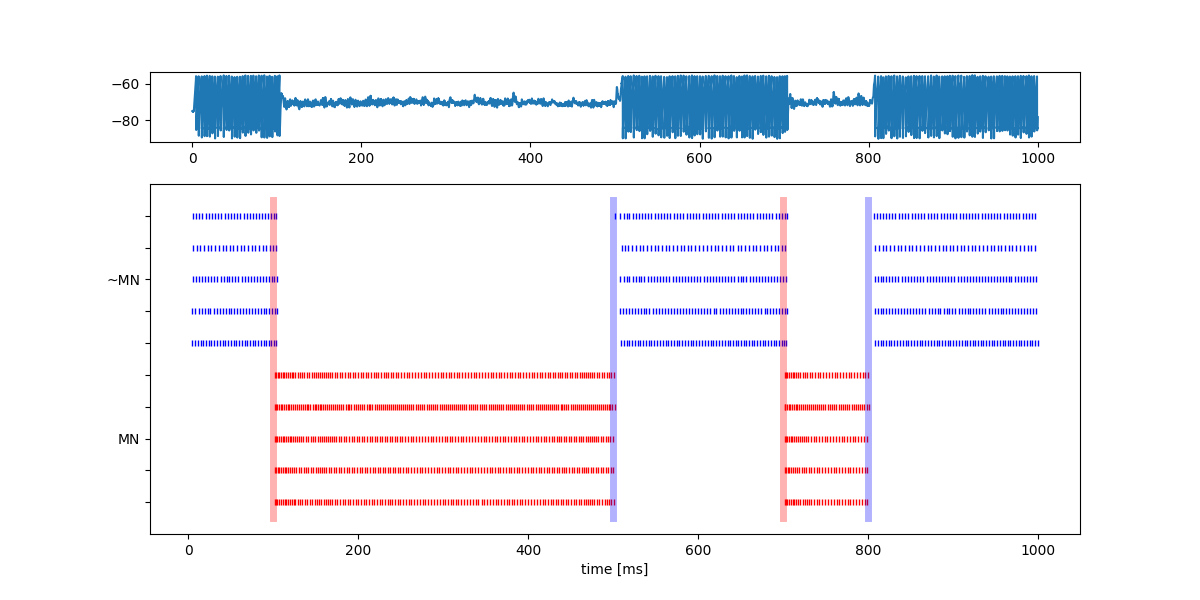

In [42]:
Image(filename="bouncing_vehicle.png")